<a href="https://colab.research.google.com/github/Lucas-Buk/Machine-Learning-Metodos-Prob/blob/main/Aula_03_GMM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Introdução**


1.   Função normal (gaussiana) unidimensional.
2.   Função normal (gaussiana) bidimensional ou N-dimensional.
3.   normalização de redução de dimensionalidade.
4.   GMM aplicado a análise de dados -  não supervisionados.
5.   Comparativo GMM e K-means.



# **Bibliotecas**

In [1]:
import numpy as np
import pandas as pd

from pylab import rcParams
from scipy import stats

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

from matplotlib import cm # Colormaps
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable

# acerta o tamanho das figuras para uma boa visualização
rcParams['figure.figsize'] = 10, 10

import sys
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

import seaborn as sns
sns.set_style('darkgrid')

# **Funções proprietárias**

In [2]:
def multivariate_normal(x, d, mean, covariance):

    x_m = x - mean
    return (1. / (np.sqrt((2 * np.pi)**d * np.linalg.det(covariance))) * 
            np.exp(-(np.linalg.solve(covariance, x_m).T.dot(x_m)) / 2))

In [3]:
def Gaussiana_1D(x, mean, variance):

    return ((1. / np.sqrt(2 * np.pi * variance)) * 
            np.exp(-(x - mean)**2 / (2 * variance)))

In [4]:
def plotData(df, groupby):
    
    fig, ax = plt.subplots(figsize = (7,7))
    cmap = mpl.cm.get_cmap('prism')

    # Pandas: http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.plot.html

    for i, cluster in df.groupby(groupby):
        cluster.plot(ax = ax, # need to pass this so all scatterplots are on same graph
                     kind = 'scatter', 
                     x = 'PC1', y = 'PC2',
                     color = cmap(i/(nclusters-1)), # cmap maps a number to a color
                     label = "%s %i" % (groupby, i), 
                     s=30) # dot size
    ax.grid()
    ax.axhline(0, color='black')
    ax.axvline(0, color='black')
    ax.set_title("Principal Components Analysis (PCA) of Iris Dataset");

In [5]:
def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))
        
def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis('equal')
    
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)

In [6]:
def plot_kmeans(kmeans, X, n_clusters=4, rseed=0, ax=None):
    labels = kmeans.fit_predict(X)

    # Data
    ax = ax or plt.gca()
    ax.axis('equal')
    ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)

    # KMeans model
    centers = kmeans.cluster_centers_
    radii = [cdist(X[labels == i], [center]).max()
             for i, center in enumerate(centers)]
    for c, r in zip(centers, radii):
        ax.add_patch(plt.Circle(c, r, fc='#CCCCCC', lw=3, alpha=0.5, zorder=1))

In [7]:
def generate_surface(mean, covariance, d):

    nb_of_x = 100 # grid size
    x1s = np.linspace(-5, 5, num=nb_of_x)
    x2s = np.linspace(-5, 5, num=nb_of_x)
    x1, x2 = np.meshgrid(x1s, x2s) 
    pdf = np.zeros((nb_of_x, nb_of_x))

    for i in range(nb_of_x):
        for j in range(nb_of_x):
            pdf[i,j] = multivariate_normal(
                np.matrix([[x1[i,j]], [x2[i,j]]]), 
                d, mean, covariance)
    return x1, x2, pdf  # x1, x2, pdf(x1,x2)

# **Dados**

O conjunto de dados de íris de Fisher é um conjunto de dados introduzido pelo estatístico, eugenista e biólogo britânico Ronald Fisher em seu artigo de 1936.

Tem os seguintes tipos de Iris 

1.   Iris setosa
2.   Iris virginica
3.   Iris versicolor

Características:

1.   comprimento e a largura das sépalas
2.   comprimento e a largura das pétalas


https://en.wikipedia.org/wiki/Iris_flower_data_set


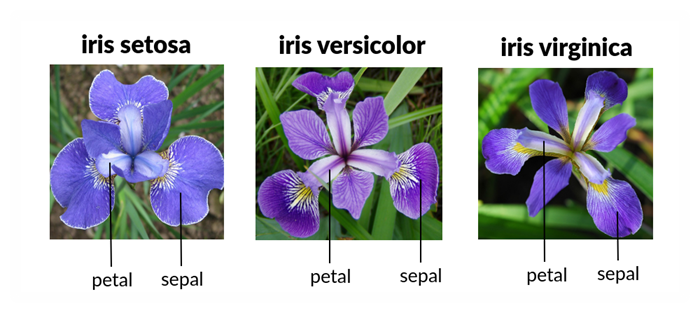

https://medium.com/@Nivitus./iris-flower-classification-machine-learning-d4e337140fa4


# **Exploração**

**Conteúdo sugerido**

Matriz de correlação ordenada por significância

Matriz de histogramas

Matriz de densidade de probabildiada. Indentifique as principais prováveis distribuições de probabilidade " por inspeção".

Mapa de calor indicando as principais correlações. o que você conclui?

Matriz de espalhamento com a diagonal principal indicando as respectivas densidades. Explore um solormap que possibilite uma boa qualidade de visualização.

Compare as densidades de probabildide para cada variável  𝑋  diferenciando se pelo tipo. Plote ambos em cores diferentes e sobrepostos visando estimar a grau de separabilidade.

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Pós/ML MP/Datasets/Iris.csv')
data = data.drop('Id', axis=1) # get rid of the Id column - don't need it
data.sample(5)

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
46,5.1,3.8,1.6,0.2,Iris-setosa
89,5.5,2.5,4.0,1.3,Iris-versicolor
32,5.2,4.1,1.5,0.1,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa
140,6.7,3.1,5.6,2.4,Iris-virginica


In [11]:
# Separando os dados de acordo com a estrutura de classificação

## Features

X = data.iloc[:,0:4]

## Categories

y = data.iloc[:,-1]

print(X.sample(5))
print(y.sample(5))

     SepalLengthCm  SepalWidthCm  PetalLengthCm  PetalWidthCm
100            6.3           3.3            6.0           2.5
58             6.6           2.9            4.6           1.3
92             5.8           2.6            4.0           1.2
79             5.7           2.6            3.5           1.0
83             6.0           2.7            5.1           1.6
71     Iris-versicolor
149     Iris-virginica
45         Iris-setosa
80     Iris-versicolor
25         Iris-setosa
Name: Species, dtype: object


In [12]:
# Contagem básica das amostras disponíveis.

data["Species"].value_counts()

Iris-setosa        50
Iris-virginica     50
Iris-versicolor    50
Name: Species, dtype: int64

In [13]:
data.columns

Index(['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm',
       'Species'],
      dtype='object')

# **Visualização**

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


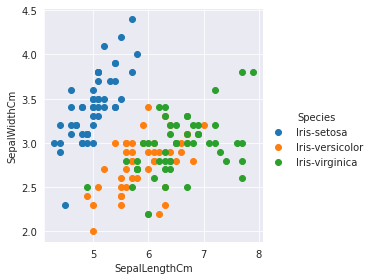

In [15]:
sns.FacetGrid(data,hue = "Species", size =4) \
   .map(plt.scatter, "SepalLengthCm", "SepalWidthCm") \
   .add_legend()

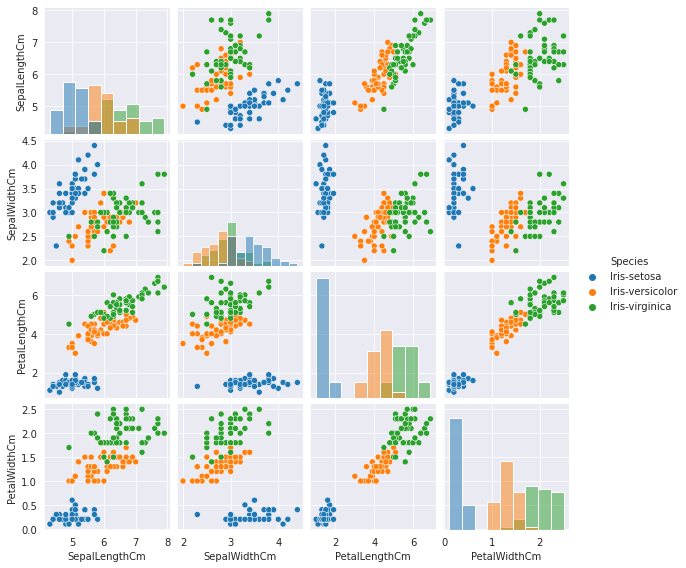

In [16]:
## Matriz de distribuições

sns.pairplot(data, hue = "Species", diag_kind = "hist", height = 2);

# **Preparando os dados**

## **Normalizando os dados**

In [17]:
X.sample(5)

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm
147,6.5,3.0,5.2,2.0
120,6.9,3.2,5.7,2.3
46,5.1,3.8,1.6,0.2
33,5.5,4.2,1.4,0.2
65,6.7,3.1,4.4,1.4


In [18]:
from sklearn import preprocessing

scaler = preprocessing.StandardScaler()

scaler.fit(X)
X_scaled_array = scaler.transform(X)
X_scaled = pd.DataFrame(X_scaled_array, columns = X.columns)

X_scaled.sample(5)

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm
69,-0.294842,-1.281972,0.080370,-0.129720
44,-0.900681,1.726266,-1.056944,-1.050031
114,-0.052506,-0.587764,0.762759,1.579429
63,0.310998,-0.356361,0.535296,0.264699
147,0.795669,-0.124958,0.819624,1.053537


## **Reduzindo a dimensionalidade - PCA** - Componentes principais

In [19]:
from sklearn.decomposition import PCA

ndimensions = 2

pca = PCA(n_components = ndimensions, random_state =  42)
pca.fit(X_scaled)
X_pca_array = pca.transform(X_scaled)
X_pca = pd.DataFrame(X_pca_array, columns=['PC1','PC2'])

X_pca.sample(5)

,PC1,PC2
0,-2.264542,0.505704
89,0.275425,-1.329816
49,-2.205954,0.032238
7,-2.233842,0.247614
65,0.875891,0.509998


# **Aplicando k-means**

In [20]:
from sklearn.cluster import KMeans

ncluster = 3
seed = 0

km = KMeans(n_clusters = ncluster, random_state = seed)
km.fit(X_scaled)

y_cluster_kmeans = km.predict(X_scaled)
y_cluster_kmeans

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 0,
       2, 2, 2, 2, 0, 2, 2, 2, 2, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 0, 0, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0,
       0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 0, 2, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0,
       0, 2, 2, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 2], dtype=int32)

In [21]:
from sklearn import metrics

score = metrics.silhouette_score(X_scaled, y_cluster_kmeans)
score

0.4589717867018717

# **Aplicando GMM**

In [22]:
from sklearn.mixture import GaussianMixture

ncluster = 3
seed = 0

gmm = GaussianMixture(n_components =  ncluster)
gmm.fit(X_scaled)

y_cluster_gmm = gmm.predict(X_scaled)
y_cluster_gmm

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 0, 2, 0, 2, 0, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [23]:
score = metrics.silhouette_score(X_scaled, y_cluster_gmm)
score

0.3727731874570307

## **Predição versus label**

In [24]:
y_id_array = pd.Categorical(data['Species']).codes

df_plot = X_pca.copy()
df_plot['ClusterKmeans'] = y_cluster_kmeans
df_plot['SpeciesId'] = y_id_array 
df_plot.sample(5)

,PC1,PC2,ClusterKmeans,SpeciesId
81,0.014118,-1.573392,2,1
21,-2.204645,0.952457,1,0
72,1.227988,-0.940915,2,1
127,1.019781,0.065543,0,2
1,-2.086426,-0.655405,1,0


### **Label original**

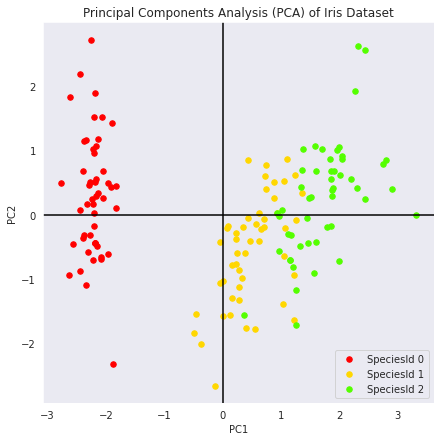

In [25]:
nclusters = 3
plotData(df_plot, 'SpeciesId')

### **K-Means**

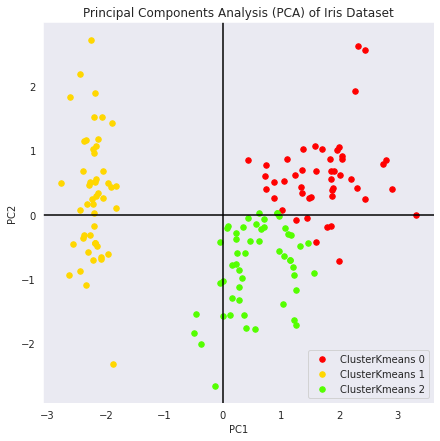

In [26]:
plotData(df_plot, 'ClusterKmeans')

### **GMM**

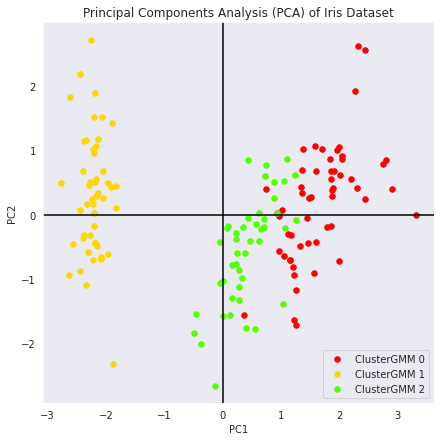

In [27]:
df_plot['ClusterGMM'] = y_cluster_gmm
plotData(df_plot, 'ClusterGMM')

## **Visualização**

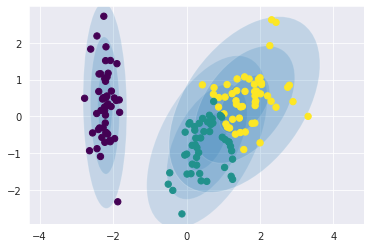

In [28]:
plot_gmm(gmm,X_pca_array)

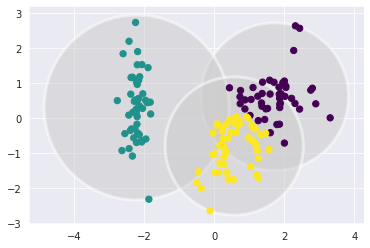

In [29]:
plot_kmeans(km,X_pca_array)

## **A função Normal e seus ajustes**

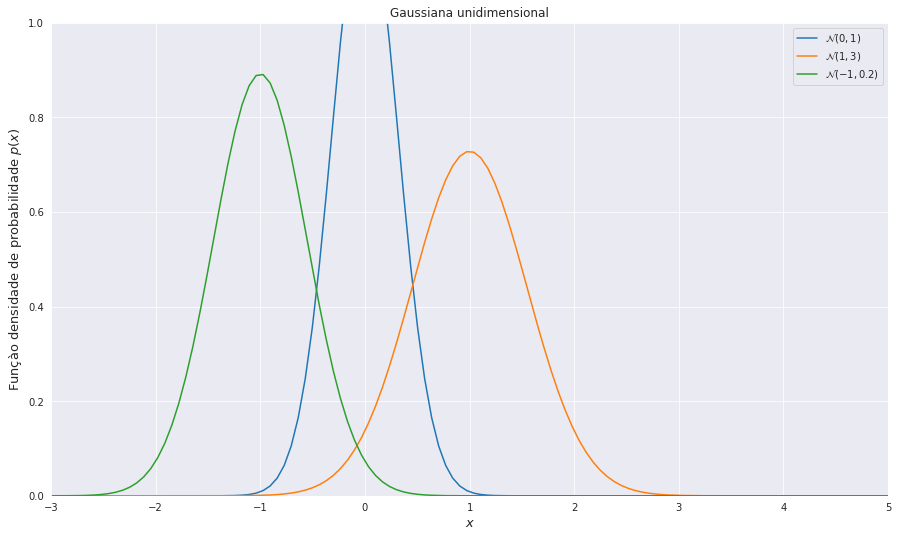

In [30]:
# Visualizando o comportamento da Normal - Gaussiana

# variável aleatória

x = np.linspace(-5, 5, num=150)

# Visualizando três valores diferentes de média e desvio padrão

fig = plt.figure(figsize=(15, 9))
plt.plot(
    x, Gaussiana_1D(x, mean=0, variance=0.1), 
    label="$\mathcal{N}(0, 1)$")
plt.plot(
    x, Gaussiana_1D(x, mean=1, variance=0.3), 
    label="$\mathcal{N}(1, 3)$")
plt.plot(
    x, Gaussiana_1D(x, mean=-1, variance=0.2), 
    label="$\mathcal{N}(-1, 0.2)$")

# Complementos

plt.xlabel('$x$', fontsize=13)
plt.ylabel('Funçào densidade de probabilidade $p(x)$', fontsize=13)
plt.title('Gaussiana unidimensional')
plt.ylim([0, 1])
plt.xlim([-3, 5])
plt.legend(loc=1)
fig.subplots_adjust(bottom=0.15)
plt.show()

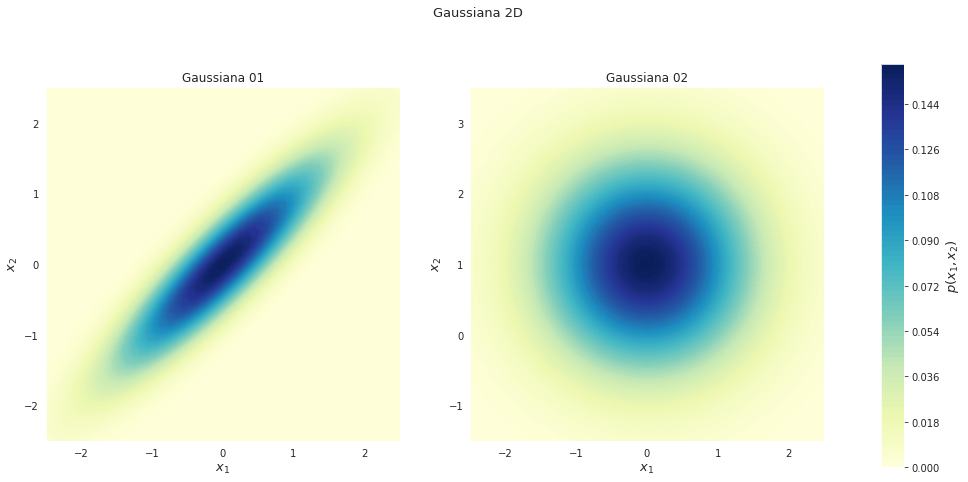

In [31]:
# Gaussiana N dimensional - 2D

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16,8))
d = 2  # dimensões

# Para as curvas normais

bivariate_mean = np.matrix([[0.], [0.]])  # Mean
bivariate_covariance = np.matrix([
    [1., 0.9], 
    [0.9, 1.]])  # Matriz de covariância

x1, x2, p = generate_surface(
    bivariate_mean, bivariate_covariance, d)

# Visualizando a Gaussiana em 2D

con = ax1.contourf(x1, x2, p, 100, cmap=cm.YlGnBu)
ax1.set_xlabel('$x_1$', fontsize=13)
ax1.set_ylabel('$x_2$', fontsize=13)
ax1.axis([-2.5, 2.5, -2.5, 2.5])
ax1.set_aspect('equal')
ax1.set_title('Gaussiana 01', fontsize=12)

# Visualizando a Gaussiana em 2D

bivariate_mean = np.matrix([[0.], [1.]])  # Mean
bivariate_covariance = np.matrix([
    [1., 0], 
    [0, 1.]])  # Matriz de covariância
x1, x2, p = generate_surface(
    bivariate_mean, bivariate_covariance, d)

# Gaussiana 2D

con = ax2.contourf(x1, x2, p, 100, cmap=cm.YlGnBu)
ax2.set_xlabel('$x_1$', fontsize=13)
ax2.set_ylabel('$x_2$', fontsize=13)
ax2.axis([-2.5, 2.5, -1.5, 3.5])
ax2.set_aspect('equal')
ax2.set_title('Gaussiana 02', fontsize=12)

# Mapa de cor com indicaçõa numérica

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
cbar = fig.colorbar(con, cax=cbar_ax)
cbar.ax.set_ylabel('$p(x_1, x_2)$', fontsize=13)
plt.suptitle('Gaussiana 2D', fontsize=13, y=0.95)
plt.show()

# **Métrica**

In [32]:
from sklearn.metrics.cluster import adjusted_rand_score

## K - means

score = adjusted_rand_score(y, y_cluster_kmeans)
score

0.6201351808870379

In [33]:
## GMM

score = adjusted_rand_score(y, y_cluster_gmm)
score

0.9038742317748124

# **Referências**

In [ ]:
########################################################################################################
# Code source: https://peterroelants.github.io/posts/multivariate-normal-primer/                       #
#                                                                                                      #
# Modified for class use and explanation about GMM clustering effect by V.C.Parro                      #
#                                                                                                      #
# Data base: Iris                                                                                      #
# License: BSD 3 clause                                                                                #
#                                                                                                      #
########################################################################################################

https://brilliant.org/wiki/gaussian-mixture-model/